In [1]:
# Import necessary libraries
import os                        # Library to interact with the operating system
import cv2                       # OpenCV library for computer vision tasks
import numpy as np               # NumPy library for numerical operations
from sklearn.datasets import fetch_lfw_people   # Function to load the LFW dataset
from sklearn.model_selection import train_test_split   # Function to split dataset into train and test subsets

# Function to split augmented dataset into training and testing subsets
def split_augmented_dataset(augmented_dir, test_size=0.2):
    # Get the list of label names (subdirectories in augmented_dir)
    label_names = os.listdir(augmented_dir)   # Fetch the names of subdirectories in the augmented dataset
    images = []   # Initialize an empty list to store images
    labels = []   # Initialize an empty list to store corresponding labels

    # Loop through each label and read images from subdirectories
    for label_idx, label_name in enumerate(label_names):
        label_dir = os.path.join(augmented_dir, label_name)   # Create the full path of the label subdirectory
        for image_file in os.listdir(label_dir):   # Loop through each image file in the subdirectory
            image_path = os.path.join(label_dir, image_file)   # Create the full path of the image file
            image = cv2.imread(image_path)   # Read the image using OpenCV
            images.append(image)   # Append the image to the images list
            labels.append(label_idx)   # Append the corresponding label to the labels list

    images = np.array(images)   # Convert the list of images to a NumPy array
    labels = np.array(labels)   # Convert the list of labels to a NumPy array

    # Split the images and labels into training and testing subsets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=42)   # Split using sklearn's train_test_split
    return X_train, X_test, y_train, y_test   # Return the training and testing subsets of images and labels

In [2]:
# Function to perform image augmentation using OpenCV
def augment_image(image):
    # Check if the image is grayscale (2-dimensional)
    if image.ndim == 2:  # Grayscale image
        # Convert the grayscale image to RGB format
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    rows, cols, _ = image.shape   # Get the dimensions of the image

    # Random rotation between -10 to 10 degrees
    random_angle = np.random.randint(-10, 11)   # Generate a random angle between -10 and 10 degrees
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), random_angle, 1)   # Get the rotation matrix for the random angle
    augmented_image = cv2.warpAffine(image, M, (cols, rows))   # Apply the rotation to the image using warpAffine

    # Random horizontal flipping
    if np.random.rand() > 0.5:   # Generate a random number between 0 and 1, and check if it's greater than 0.5
        flipped_image = cv2.flip(augmented_image, 1)  # 1 means horizontal flip. Flip the image horizontally
    else:
        flipped_image = augmented_image   # Keep the image as is (no horizontal flip)

    # Random brightness adjustment
    brightness_factor = np.random.uniform(0.7, 1.3)   # Generate a random brightness factor between 0.7 and 1.3
    hsv_image = cv2.cvtColor(flipped_image, cv2.COLOR_RGB2HSV)   # Convert the RGB image to HSV color space
    hsv_image[:, :, 2] = hsv_image[:, :, 2] * brightness_factor   # Adjust the brightness (V channel) by the brightness factor
    augmented_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)   # Convert the HSV image back to RGB color space

    return augmented_image   # Return the augmented image

In [3]:
import matplotlib.pyplot as plt

In [35]:
def augment_lfw_people_dataset(lfw_people, target_count=10, output_directory='lfw_augmented'):
    # Create a new directory for the augmented dataset
    augmented_dir = os.path.join(lfw_people.target_names[0], output_directory)   # Create the full path of the augmented directory
    os.makedirs(augmented_dir, exist_ok=True)   # Create the augmented directory if it doesn't exist

    # Loop through each label in the dataset
    for label_idx, label_name in enumerate(lfw_people.target_names):
        label_dir = os.path.join(augmented_dir, label_name)   # Create the full path of the label subdirectory
        os.makedirs(label_dir, exist_ok=True)   # Create the label subdirectory if it doesn't exist

        # Get images belonging to the current label
        label_images = lfw_people.images[lfw_people.target == label_idx]   # Fetch the images with the current label

        # Check if the label folder already has enough images (>= target_count)
        if len(label_images) >= target_count:   # If the label already has enough images
            selected_images = label_images[:target_count]   # Select the first target_count number of images
        else:
            # If the label folder has fewer images, duplicate and augment the existing images
            selected_images = []
            while len(selected_images) < target_count:
                for image in label_images:
                    selected_images.append(augment_image(image))   # Augment the image and add to selected_images
                    if len(selected_images) == target_count:   # Check if we have enough augmented images
                        break

        # Perform augmentation for images with count < target_count
        for idx, image in enumerate(selected_images):
            image_path = os.path.join(label_dir, f'{label_name}_{idx}.png')   # Create the full path of the augmented image
            # image = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            image = cv2.convertScaleAbs(image, alpha=(255.0))
            cv2.imwrite(image_path, image)
            # plt.imsave(image_path, image)

In [36]:
# Load the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=1, resize=0.4)   # Fetch the LFW dataset with specified parameters

# Augment the LFW dataset
augment_lfw_people_dataset(lfw_people, target_count=10)   # Augment the dataset with 10 images per class

# Split the augmented dataset into training and testing subsets
augmented_dir = os.path.join(lfw_people.target_names[0], 'lfw_augmented')   # Create the full path of the augmented directory
X_train, X_test, y_train, y_test = split_augmented_dataset(augmented_dir, test_size=0.2)   # Split the dataset into train and test subsets


In [37]:
import matplotlib.pyplot as plt

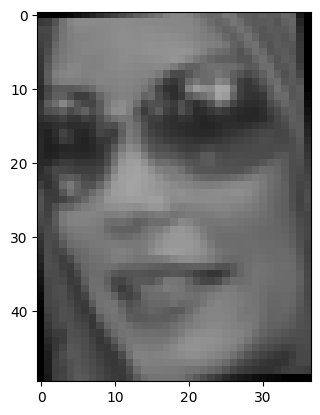

In [38]:
image = plt.imread("./AJ Cook/lfw_augmented/Angie Martinez/Angie Martinez_4.png")
plt.imshow(image)

In [39]:
import os
from sklearn.datasets import fetch_lfw_people

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score



# Convert the labels to one-hot encoded format (categorical)
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

# Normalize the pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(50, 37, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 40




2023-08-03 02:39:52.598212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-03 02:39:52.610765: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-03 02:39:52.612407: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-03 02:39:52.614501: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [40]:
import tensorflow as tf
with tf.device('/GPU:0'):
    history = model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_labels)

Epoch 1/40


2023-08-03 02:39:56.668033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-08-03 02:39:58.092184: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fc32f2f7b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-03 02:39:58.092230: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-08-03 02:39:58.099481: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-03 02:39:58.258911: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1150/1150 [==============================] - 11s 6ms/step - loss: 8.6717 - accuracy: 1.9025e-04 - val_loss: 8.6312 - val_accuracy: 0.0015
Epoch 2/40
1150/1150 [==============================] - 6s 5ms/step - loss: 8.2488 - accuracy: 0.0039 - val_loss: 7.7909 - val_accuracy: 0.0125
Epoch 3/40
1150/1150 [==============================] - 6s 5ms/step - loss: 7.0136 - accuracy: 0.0278 - val_loss: 6.4642 - val_accuracy: 0.0922
Epoch 4/40
1150/1150 [==============================] - 6s 5ms/step - loss: 5.9216 - accuracy: 0.0840 - val_loss: 5.3422 - val_accuracy: 0.2233
Epoch 5/40
1150/1150 [==============================] - 6s 5ms/step - loss: 5.0828 - accuracy: 0.1572 - val_loss: 4.4375 - val_accuracy: 0.3522
Epoch 6/40
1150/1150 [==============================] - 6s 5ms/step - loss: 4.4952 - accuracy: 0.2163 - val_loss: 3.8517 - val_accuracy: 0.4431
Epoch 7/40
1150/1150 [==============================] - 6s 5ms/step - loss: 4.0140 - accuracy: 0.2785 - val_loss: 3.4207 - val_accuracy: 0.512

In [41]:
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 84.38%


In [43]:
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(50, 37, 3),
    include_top=False)


In [54]:
base_model.trainable = True

In [55]:
inputs = tf.keras.Input(shape=(50, 37, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=True)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = Dense(num_classes, activation='softmax')(x)
# outputs = keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

In [56]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 40

In [ ]:
import tensorflow as tf
with tf.device('/GPU:0'):
    history = model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
accuracy = accuracy_score(y_test, y_pred_labels)

Epoch 1/40
1150/1150 [==============================] - 92s 54ms/step - loss: 8.3444 - accuracy: 6.7948e-04 - val_loss: 7.7121 - val_accuracy: 0.0016
Epoch 2/40
1150/1150 [==============================] - 60s 52ms/step - loss: 6.6918 - accuracy: 0.0155 - val_loss: 6.4077 - val_accuracy: 0.0240
Epoch 3/40
1150/1150 [==============================] - 60s 52ms/step - loss: 5.1617 - accuracy: 0.0890 - val_loss: 5.1945 - val_accuracy: 0.1143
Epoch 4/40
1150/1150 [==============================] - 60s 52ms/step - loss: 3.5981 - accuracy: 0.2895 - val_loss: 3.6577 - val_accuracy: 0.3615
Epoch 5/40
1150/1150 [==============================] - 60s 52ms/step - loss: 2.1936 - accuracy: 0.5564 - val_loss: 2.5769 - val_accuracy: 0.5733
Epoch 6/40
1150/1150 [==============================] - 60s 52ms/step - loss: 1.3021 - accuracy: 0.7298 - val_loss: 1.9548 - val_accuracy: 0.7013
Epoch 7/40
1150/1150 [==============================] - 60s 52ms/step - loss: 0.8005 - accuracy: 0.8292 - val_loss: 1.63

In [59]:
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 87.62%


In [ ]:
classification_report_str = classification_report(y_test, y_pred_labels, target_names=y_train)
print("Classification Report:")
print(classification_report_str)